# Download all survey data

This notebook will download all survey data available on the [NOAA NCEI Aeromagnetic data catalogue](https://www.ngdc.noaa.gov/geomag/aeromag.shtml). These are global **public domain** datasets.

In [1]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import pooch
import requests
from tqdm import tqdm

Save all files to the `data` folder and place the zip files with the survey data in the `data/raw` folder.

In [2]:
output = Path("..") / "data"
output_raw = output / "raw"

## Survey catalogue

First, we download a catalogue of all survey metadata and download links. I found this JSON file by inspecting the source of the NOAA page (apparently it's used to populate the table in the page using Javascript). We can use it to find download links to all surveys.

In [3]:
catalogue_url = "https://www.ngdc.noaa.gov/geomag/aeromag-project.txt"
catalogue_hash = "sha256:162e30f2d2542e96bd215b8b51f1585a3282e5fc6c225507588812f524b0d2a2"
catalogue_file = pooch.retrieve(
    catalogue_url, 
    known_hash=catalogue_hash, 
    path=output, 
    fname="noaa-aeromag-catalogue.json", 
    downloader=pooch.HTTPDownloader(progressbar=True)
)

100%|███████████████████████████████████████| 251k/251k [00:00<00:00, 83.9MB/s]


Now we can read in the catalogue as a `dict` using Python's `json` module.

In [4]:
with open(catalogue_file) as file:
    catalogue = json.load(file)["data"] 
    
print(f"There are {len(catalogue)} surveys available.")

There are 139 surveys available.


The catalogue is a list of dictionaries with survey metadata and some links. Here is an example:

In [5]:
catalogue[0]

{'SURVEY_ID': 'NRL_LINCOLN-SEA75',
 'FORMAT_88': 'MAG88T',
 'PARAMS_CO': 'TR',
 'DATE_CREAT': 20140627,
 'INST_SRC': 'US Naval Research Laboratory',
 'COUNTRY': 'United States',
 'PLATFORM': 'RP-3-A Navy Buno 149670',
 'PLAT_TYP': 'Airplane',
 'CHIEF': 'R.H. Feden',
 'PROJECT': 'Lincoln Sea',
 'DATE_DEP': 19750417,
 'PORT_DEP': 'Thule, Greenland',
 'DATE_ARR': 19750503,
 'PORT_ARR': 'Thule, Greenland',
 'POS_INFO': 'Litton 51 INS',
 'LAT_TOP': 87.66,
 'LAT_BOTTOM': 73.37,
 'LON_LEFT': -146.81,
 'LON_RIGHT': -9.99,
 'TRK_SPACE': 'NE - SW: 9.0 to 17.0 Kilometers',
 'NOM_ALT': '300 meters ASL',
 'NOM_SPEED': '138.4 knots ave calculated',
 'TOTAL_OBS': 129421,
 'TOTAL_DIST': 18850,
 'INSTRUMENT': 'Geometrics G-801/3 Proton Precession',
 'SAMP_RATE': '2.5 seconds',
 'TOW_DIST': '',
 'SENSITIV': '',
 'REF_FIELD': 'DGRF',
 'ADD_DOC': 'A write up about the survey can be found in the "Journal of Geophysical Research", vol 84, no. B3, p. 1071 - 1089, 1979',
 'DATE_ADDED': '27-Jun-14',
 'PROJECT_

What we're after is the `Survey_Data` URL. We should make sure that all entries in the catalogue have one of those.

In [6]:
assert all("Survey_Data" in entry for entry in catalogue)

## Estimate total download size

Before commiting to download, let's see how much disk space will be required. We can ping the server and ask for the size of each file. 

**Warning**: The size reported by the server can be wrong so be careful not to run out of disk space.

In [7]:
file_sizes = []
failed = []
for entry in tqdm(catalogue, ncols=100):
    response = requests.get(entry["Survey_Data"], stream=True)
    # Keep track of any failed requests
    if response.status_code != 200:
        failed.append(entry["SURVEY_ID"])
    # Convert bytes to MB
    file_sizes.append(int(response.headers["Content-length"]) * 1e-6)

100%|█████████████████████████████████████████████████████████████| 139/139 [02:20<00:00,  1.01s/it]


Check if any of the requests failed.

In [8]:
print("Failed connections:")
for i, survey in enumerate(failed):
    print(f"  {i + 1}: {survey}")

Failed connections:
  1: DTU_ICEGRAV-PENINSULA1
  2: DTU_ICEGRAV-PENINSULA2
  3: DTU_ICEGRAV-PENINSULA3
  4: DTU_ICEGRAV-TROLL
  5: MAGCAS
  6: MAG1
  7: MAGCAV
  8: MAGSIL


There seems to be issues with the server not finding these surveys so we'll likely not be able to download them.

Now we can calculate the total download size for the surveys that are available.

In [9]:
print(f"Total download size: {sum(file_sizes)} MB")

Total download size: 4173.499881000002 MB


We can also plot a historgram of the file size so we know what to expect from individual surveys.

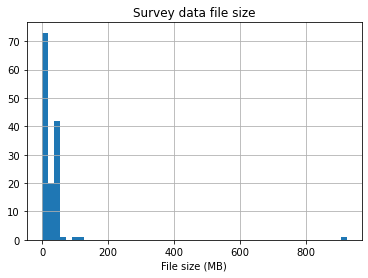

In [10]:
plt.figure()
plt.title("Survey data file size")
plt.hist(file_sizes, bins="auto")
plt.xlabel("File size (MB)")
plt.grid()
plt.show()

## Download survey archives

Each survey is archived in a zip file with the line magnetic data in an ASCII format (mg88t with a header and a main file). We can download all of the files to the output folder using Pooch. We'll need to disable the Pooch logger so that it doesn't print the "Downloading..." message 100s of times.

In [11]:
pooch.get_logger().disabled = True

failed = []
for entry in tqdm(catalogue, ncols=100):
    url = entry["Survey_Data"]
    try:
        pooch.retrieve(url, known_hash=None, path=output_raw, fname=url.split("/")[-1])
    except:
        failed.append(entry["SURVEY_ID"])
        
pooch.get_logger().disabled = False

100%|█████████████████████████████████████████████████████████████| 139/139 [00:06<00:00, 20.92it/s]


Check if the same surveys failed again.

In [12]:
print("Download failed:")
for i, survey in enumerate(failed):
    print(f"  {i + 1}: {survey}")

Download failed:
  1: DTU_ICEGRAV-PENINSULA1
  2: DTU_ICEGRAV-PENINSULA2
  3: DTU_ICEGRAV-PENINSULA3
  4: DTU_ICEGRAV-TROLL
  5: MAGCAS
  6: MAG1
  7: MAGCAV
  8: MAGSIL


Verify that the right number of files exist in the directory.

In [13]:
archives = list(output_raw.glob("*.zip"))
assert len(archives) == len(catalogue) - len(failed)

Check the actual size of the datasets on disk.

In [14]:
download_sizes = [archive.stat().st_size * 1e-6 for archive in archives]
print(f'Total downloaded size: {sum(download_sizes)} MB')

Total downloaded size: 4082.5902589999996 MB


Not exactly the same but close enough.